In [3]:
%matplotlib inline

In [4]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

In [36]:
# grab the formatted data 
data = ascii.read("data/visual_data_besselian.csv", format="csv", fill_values=[("X", '0')])

# convert years 
jds = Time(np.ascontiguousarray(data["epoch"]), format="byear").jd

In [37]:
data

<Table masked=True length=12>
  epoch   object   rho   rho_err    PA    PA_err   ref   
 float64  int64  float64 float64 float64 float64   str8  
--------- ------ ------- ------- ------- ------- --------
1992.0216      1     1.4      --   230.0      -- Rep1993b
  1998.14      1    1.44    0.01   215.4     1.0     none
 1998.496      1   1.469   0.001  216.11    0.03     none
 2003.136      1   1.481   0.003   213.4     0.5     none
 2004.143      1   1.477   0.006  215.78    0.09     none
2010.0698      1   1.526      --   208.9      -- Msn2018a
  2010.08      1   1.504   0.015   209.1     0.3 Jnn2014b
  2010.08      1   1.523   0.001   209.3     0.3  Jnn2012
2014.2646      1  1.5124  0.0181 207.387   0.687     none
 2014.303      1   1.544  0.0048  207.65    0.18     none
 2015.001      1   1.541      -- 207.165      -- Kpp2018m
2015.0277      1  1.5504  0.0007   207.1      -- Tok2015c

In [38]:
data["rho_err"][data["rho_err"].mask == True] = 0.05
data["PA_err"][data["PA_err"].mask == True] = 5.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns

rho_data = np.ascontiguousarray(data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(data["PA_err"] * deg) # radians

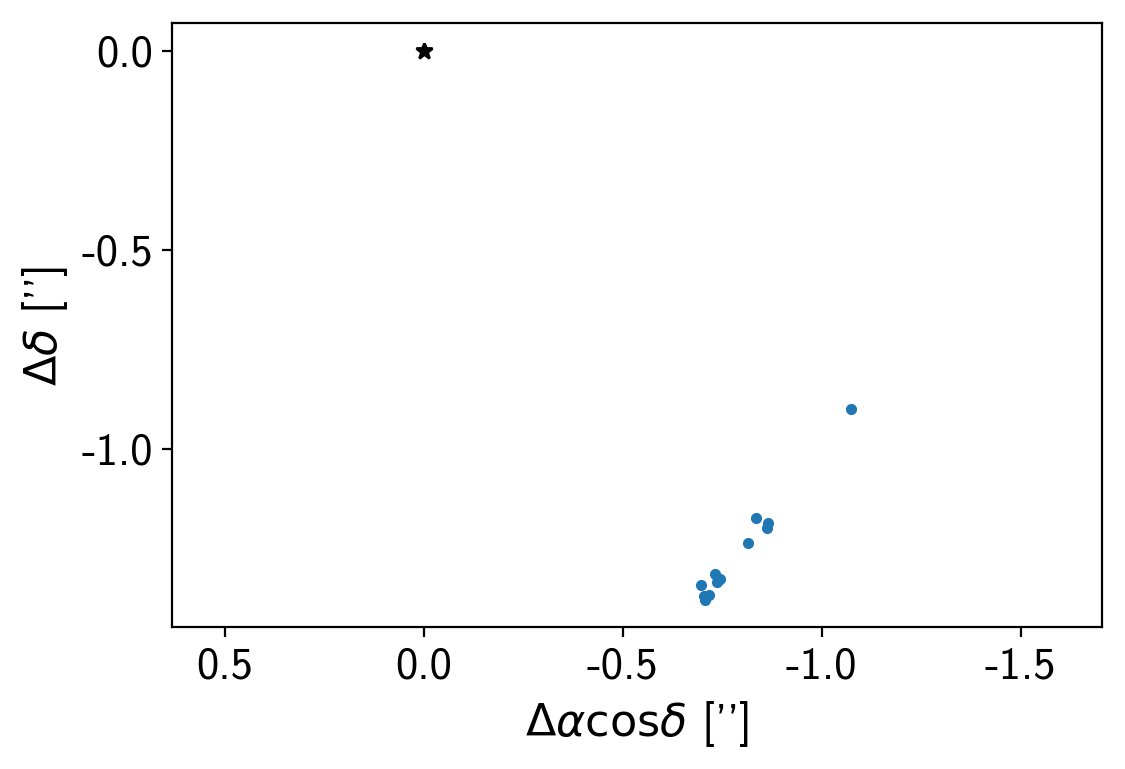

In [9]:
# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left

fig, ax = plt.subplots(nrows=1)

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

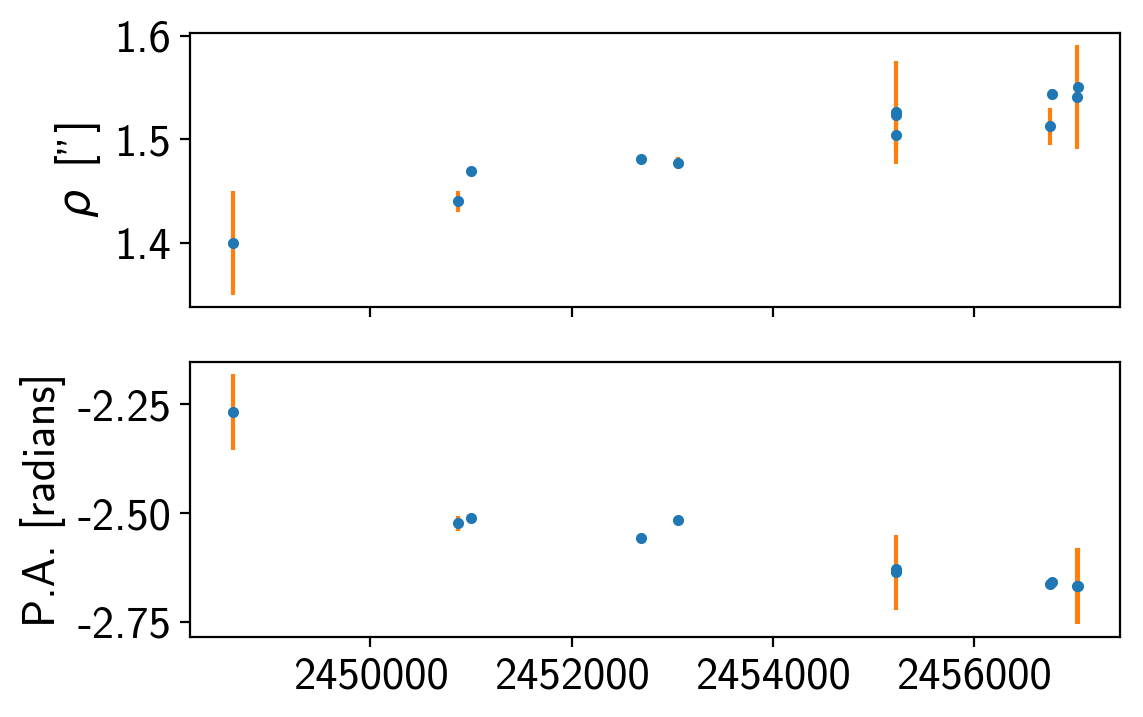

In [39]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(jds, rho_data, ".")
ax[0].errorbar(jds, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(jds, theta_data, ".")
ax[1].errorbar(jds, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

In [11]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

In [12]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [13]:
# to get started, we'll use the best-fit parameters from Kellogg

# conversion constant
au_to_R_sun = (constants.au / constants.R_sun).value

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 3.3 # arcsec
parallax = 27.31 # miliarcsec 
dpc = 1e3 / parallax
   
# 27.31 mas +/- 0.12 mas # from GAIA
    
a = a_ang * dpc

print(a)
e = 0.40
i = 120.0 * deg # [rad]
omega = 200.0 * deg # omega_1
Omega = 160.0 * deg


P = 200 * yr # days

T0 = Time(2020.0, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

# n = 2 * np.pi / P
# t0 = (phi + w) / n

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega)

# make a theano function to get stuff from orbit 
times = tt.vector("times")

# pos = orbit.get_relative_position(times) # the X, Y, Z coordinates
ang = orbit.get_relative_angles(times) # the rho, theta coordinates

# f_pos = theano.function([times], pos)
f_ang = theano.function([times], ang)

t = np.linspace(T0 - P, T0 + P, num=200) # days

# # anoms = f_anom(t)
# X, Y, Z = f_pos(t)
rho_phys, theta = f_ang(t)
rho = (rho_phys / au_to_R_sun) / dpc # arcsec

120.83485902599779
plus 0.0
minus -0.6981317007977319


In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(t, rho)
ax[0].plot(jds, rho_data, ".")
ax[0].errorbar(jds, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta)
ax[1].plot(jds, theta_data, ".")
ax[1].errorbar(jds, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

In [89]:
np.exp(1)

2.718281828459045

In [90]:
# Set up the model in PyMC3

zeros = np.zeros_like(jds)
jd0 = jds[0]
t_fine = np.linspace(0, 1, num=500)
t_data = np.linspace(-yr, jds[-1] - jd0 + yr)

with pm.Model() as parallax_model:

    # We'll include the parallax data as a prior on the parallax value 
    
    # 27.31 mas +/- 0.12 mas # from GAIA
    parallax = pm.Normal("parallax", mu=27.31, sd=0.12) # milliarcsec 
    a_ang = pm.Uniform("a_ang", 0.1, 4.0, testval=2.0) # arcsec 
    
    # the distance to the source in parcsecs
    dpc = pm.Deterministic("dpc", 1e3 / parallax)
    
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang * dpc) # au
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Normal("logP", mu=np.log(400), sd=1.0)
    P = pm.Deterministic("P", tt.exp(logP) * yr) # days
    
    omega = Angle("omega", testval=180 * deg) # - pi to pi
    Omega = Angle("Omega", testval=0 * deg) # - pi to pi
      
    phi = Angle("phi", testval=2.)
    
    n = 2*np.pi*tt.exp(-logP) / yr
    
    t_periastron = (phi + omega) / n
    
    cos_incl = pm.Uniform("cosIncl", lower=-1., upper=1.0, testval=np.cos(3.0))
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.3)
           
    # now that we have a physical scale defined, we can also calculate the total mass of the system 
    Mtot = pm.Deterministic("Mtot", calc_Mtot(a, P))
        
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega)
    
    rho_phys, theta_model = orbit.get_relative_angles(jds - jd0) # the rho, theta model values
    
    # because we've specified a physical value for a, a is now actually in units of R_sun
    # So, we'll want to convert back to arcsecs 
    rho_model = (rho_phys / au_to_R_sun) / dpc # arcsec
    
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=2.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=2.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    
    # we need to calculate the difference 
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)
    
    t_period = pm.Deterministic("tPeriod", t_fine * P)
    
    # save some samples on a fine orbit for plotting purposes
    rho, theta = orbit.get_relative_angles(t_period)
    rho_save_sky = pm.Deterministic("rhoSaveSky", rho / au_to_R_sun / dpc)
    theta_save_sky = pm.Deterministic("thetaSaveSky", theta)
    
    rho, theta = orbit.get_relative_angles(t_data)
    rho_save_data = pm.Deterministic("rhoSaveData", rho / au_to_R_sun / dpc)
    theta_save_data = pm.Deterministic("thetaSaveData", theta)

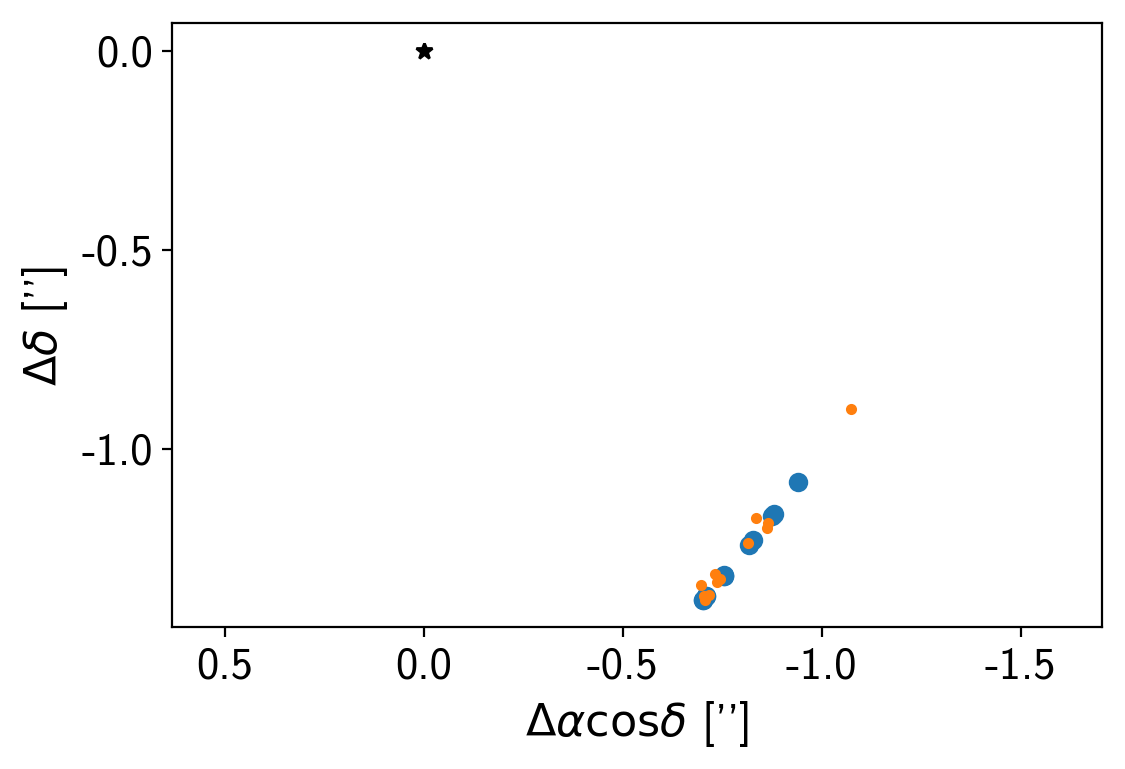

In [93]:
fig, ax = plt.subplots(nrows=1)

with parallax_model:
    rho = xo.eval_in_model(rho_model, map_sol3)
    theta = xo.eval_in_model(theta_model, map_sol3)
  
    # plot the orbit 
    xs = rho * np.cos(theta) # X is north
    ys = rho * np.sin(theta) # Y is east
    ax.plot(ys, xs, "o")

    # plot the data
    xs = rho_data * np.cos(theta_data) # X is north
    ys = rho_data * np.sin(theta_data) # Y is east
    ax.plot(ys, xs, ".")

    ax.set_ylabel(r"$\Delta \delta$ ['']")
    ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
    ax.invert_xaxis()
    ax.plot(0,0, "k*")
    ax.set_aspect("equal", "datalim")

In [91]:
with parallax_model:
    map_sol0 = xo.optimize(vars=[a_ang, phi])
    map_sol1 = xo.optimize(map_sol0, vars=[a_ang, phi, omega, Omega])
    map_sol2 = xo.optimize(map_sol1, vars=[a_ang, logP, phi, omega, Omega, incl, e])
    map_sol3 = xo.optimize(map_sol2)

optimizing logp for variables: ['phi_angle__', 'a_ang_interval__']
message: Optimization terminated successfully.
logp: -24111.267736462964 -> 57.26274203875133
optimizing logp for variables: ['Omega_angle__', 'omega_angle__', 'phi_angle__', 'a_ang_interval__']
message: Optimization terminated successfully.
logp: 57.26274203875133 -> 104.28943720455578
optimizing logp for variables: ['e_interval__', 'incl_interval__', 'Omega_angle__', 'omega_angle__', 'phi_angle__', 'logP', 'a_ang_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: 104.28943720455578 -> 108.14701252503785
optimizing logp for variables: ['logThetaS', 'logRhoS', 'e_interval__', 'incl_interval__', 'phi_angle__', 'Omega_angle__', 'omega_angle__', 'logP', 'a_ang_interval__', 'parallax']
message: Optimization terminated successfully.
logp: 108.14701252503785 -> 112.09491522541765


In [ ]:
with parallax_model:
    
    fig, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].plot(jds, xo.eval_in_model(rho_model, map_sol3), "o")
    ax[0].plot(jds, rho_data, ".")
    ax[0].errorbar(jds, rho_data, yerr=rho_err, ls="")
    ax[0].set_ylabel(r'$\rho\,$ ["]')

    ax[1].plot(jds, xo.eval_in_model(theta_model, map_sol3), "o")
    ax[1].plot(jds, theta_data, ".")
    ax[1].errorbar(jds, theta_data, yerr=theta_err, ls="")
    ax[1].set_ylabel(r'P.A. [radians]');

In [94]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(finish=500, chains=4)
with parallax_model:
    burnin = sampler.tune(tune=2000, start=map_sol3, step_kwargs=dict(target_accept=0.95))
#     print("sampling trace")
    trace = sampler.sample(draws=7000)
#     trace = pm.sample(draws=1000, tune=4000, start=map_sol3, chains=2, step_kwargs=dict(target_accept=0.99))

Sampling 4 chains: 100%|██████████| 2008/2008 [05:11<00:00,  2.82draws/s]
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [logThetaS, logRhoS, e, incl, phi, Omega, omega, logP, a_ang, parallax]
INFO:pymc3:NUTS: [logThetaS, logRhoS, e, incl, phi, Omega, omega, logP, a_ang, parallax]
Sampling 4 chains: 100%|██████████| 28000/28000 [1:41:52<00:00,  1.92draws/s]  
There were 345 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 345 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 386 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 386 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Th

In [95]:
pm.summary(trace)

mean             sd     mc_error       hpd_2.5  \
parallax               27.309110       0.119488     0.001153     27.074732   
logP                    6.399445       0.510629     0.008562      5.380710   
logRhoS                -4.779540       0.438293     0.004827     -5.650383   
logThetaS              -3.778389       0.307880     0.003091     -4.347247   
a_ang                   1.900426       0.595605     0.012593      0.967776   
dpc                    36.618518       0.160227     0.001547     36.308756   
a                      69.590968      21.814576     0.462363     36.044406   
P                  250215.542694  134485.759010  2188.736662  56484.123257   
omega                   0.140878       1.798602     0.034910     -2.738891   
Omega                   0.264246       1.821466     0.041558     -2.867704   
phi                    -0.086978       1.762059     0.053315     -2.955846   
incl                    2.506623       0.339883     0.007397      1.987382   
e                       0.357095       0.181719     0.003502      0.000197   
Mtot                    1.031100       1.339348     0.026865      0.210467   
tPeriod__0              0.000000       0.000000     0.000000      0.000000   
tPeriod__1            501.433953     269.510539     4.386246    113.194636   
tPeriod__2           1002.867907     539.021078     8.772492    226.389272   
tPeriod__3           1504.301860     808.531617    13.158737    339.583907   
tPeriod__4           2005.735813    1078.042156    17.544983    452.778543   
tPeriod__5           2507.169766    1347.552695    21.931229    565.973179   
tPeriod__6           3008.603720    1617.063235    26.317475    679.167815   
tPeriod__7           3510.037673    1886.573774    30.703721    792.362451   
tPeriod__8           4011.471626    2156.084313    35.089967    905.557086   
tPeriod__9           4512.905580    2425.594852    39.476212   1018.751722   
tPeriod__10          5014.339533    2695.105391    43.862458   1131.946358   
tPeriod__11          5515.773486    2964.615930    48.248704   1245.140994   
tPeriod__12          6017.207440    3234.126469    52.634950   1358.335629   
tPeriod__13          6518.641393    3503.637008    57.021196   1471.530265   
tPeriod__14          7020.075346    3773.147547    61.407441   1584.724901   
tPeriod__15          7521.509299    4042.658086    65.793687   1697.919537   
...                          ...            ...          ...           ...   
thetaSaveData__20      -2.529681       0.012303     0.000090     -2.553751   
thetaSaveData__21      -2.535102       0.011784     0.000085     -2.558711   
thetaSaveData__22      -2.540503       0.011299     0.000080     -2.562950   
thetaSaveData__23      -2.545883       0.010852     0.000075     -2.567660   
thetaSaveData__24      -2.551244       0.010445     0.000071     -2.571927   
thetaSaveData__25      -2.556586       0.010085     0.000067     -2.577326   
thetaSaveData__26      -2.561907       0.009775     0.000063     -2.581929   
thetaSaveData__27      -2.567209       0.009519     0.000061     -2.587016   
thetaSaveData__28      -2.572492       0.009322     0.000058     -2.591321   
thetaSaveData__29      -2.577756       0.009186     0.000057     -2.596438   
thetaSaveData__30      -2.583001       0.009114     0.000056     -2.600981   
thetaSaveData__31      -2.588226       0.009106     0.000057     -2.607309   
thetaSaveData__32      -2.593433       0.009161     0.000058     -2.612112   
thetaSaveData__33      -2.598622       0.009279     0.000059     -2.617293   
thetaSaveData__34      -2.603791       0.009455     0.000062     -2.622449   
thetaSaveData__35      -2.608943       0.009686     0.000065     -2.628312   
thetaSaveData__36      -2.614076       0.009968     0.000068     -2.634187   
thetaSaveData__37      -2.619191       0.010296     0.000072     -2.640072   
thetaSaveData__38      -2.624287       0.010665     0.000076     -2.645986   
thetaSaveData__39      -2.629366       0.011070   

In [ ]:
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "incl", "phi"])

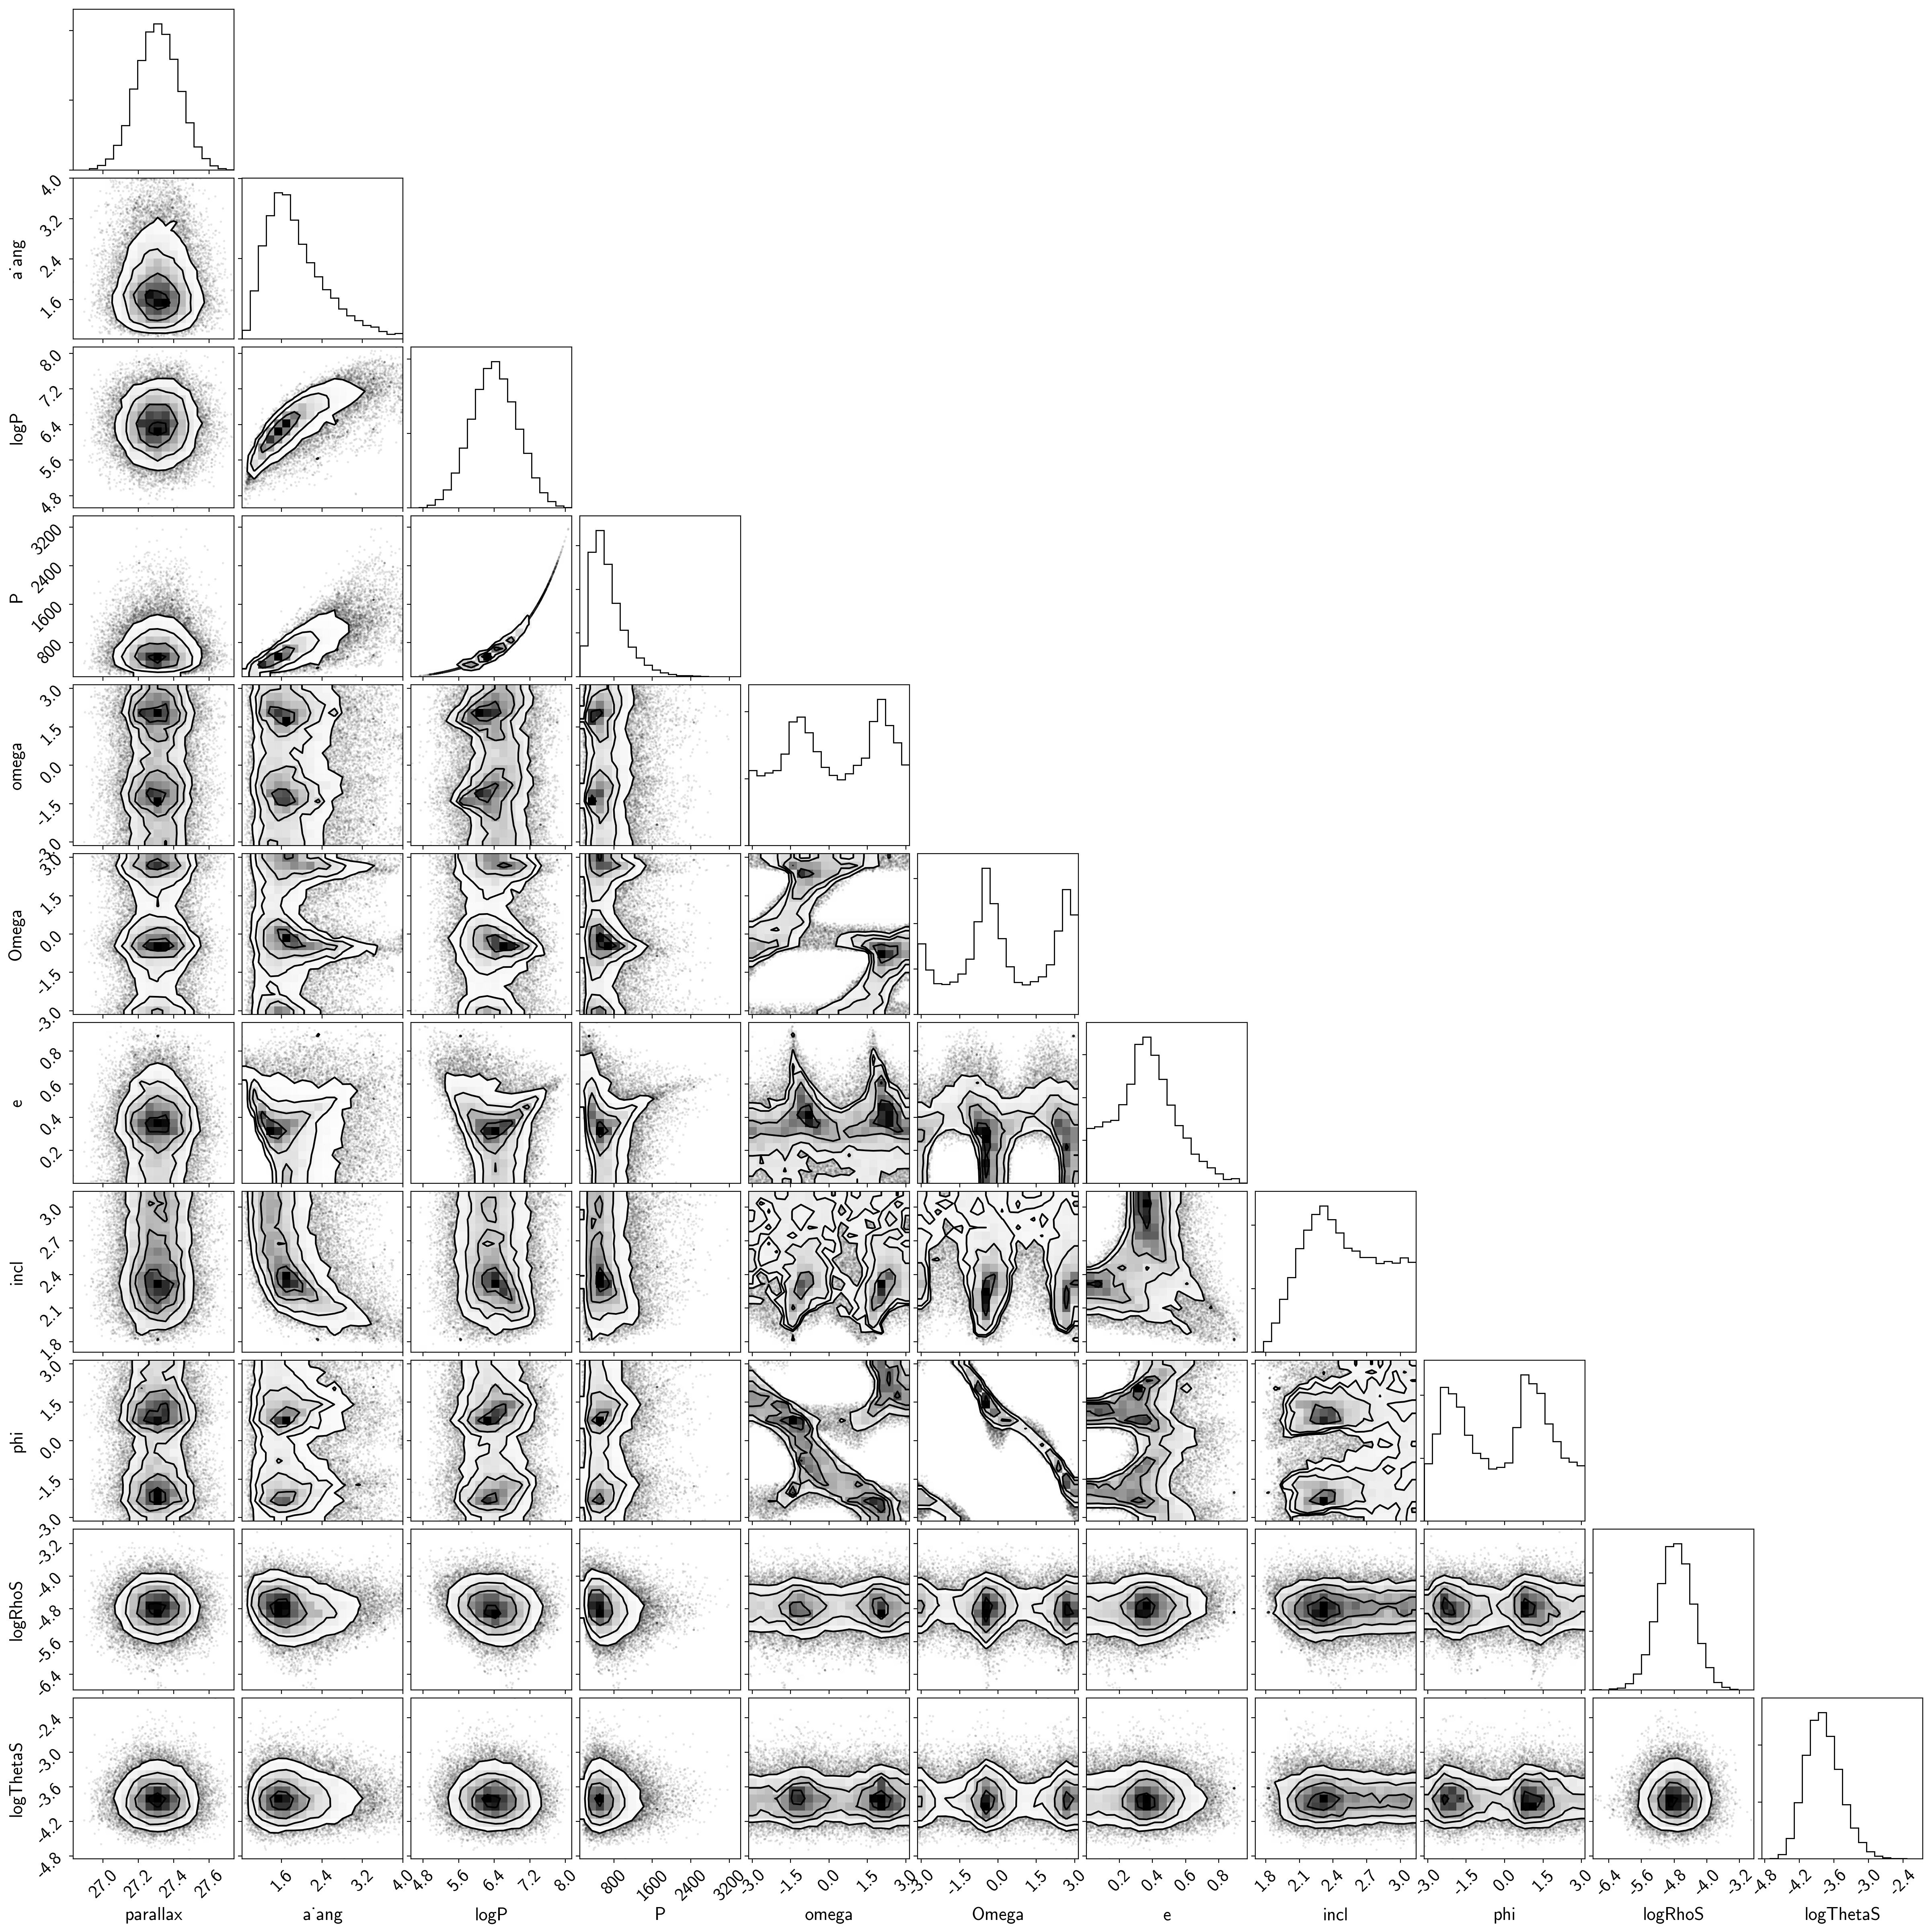

In [97]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["parallax", "a_ang", "logP", "P", "omega", "Omega", "e", 
                                        "incl", "phi", "logRhoS", "logThetaS"])

samples["P"] /= yr
corner.corner(samples);

In [ ]:
320000 / yr

In [ ]:
samples = pm.trace_to_dataframe(trace, varnames=["parallax", "a_ang", "P", "phi"])
samples["P"] /= yr
corner.corner(samples);

In [49]:
len(trace)

1000

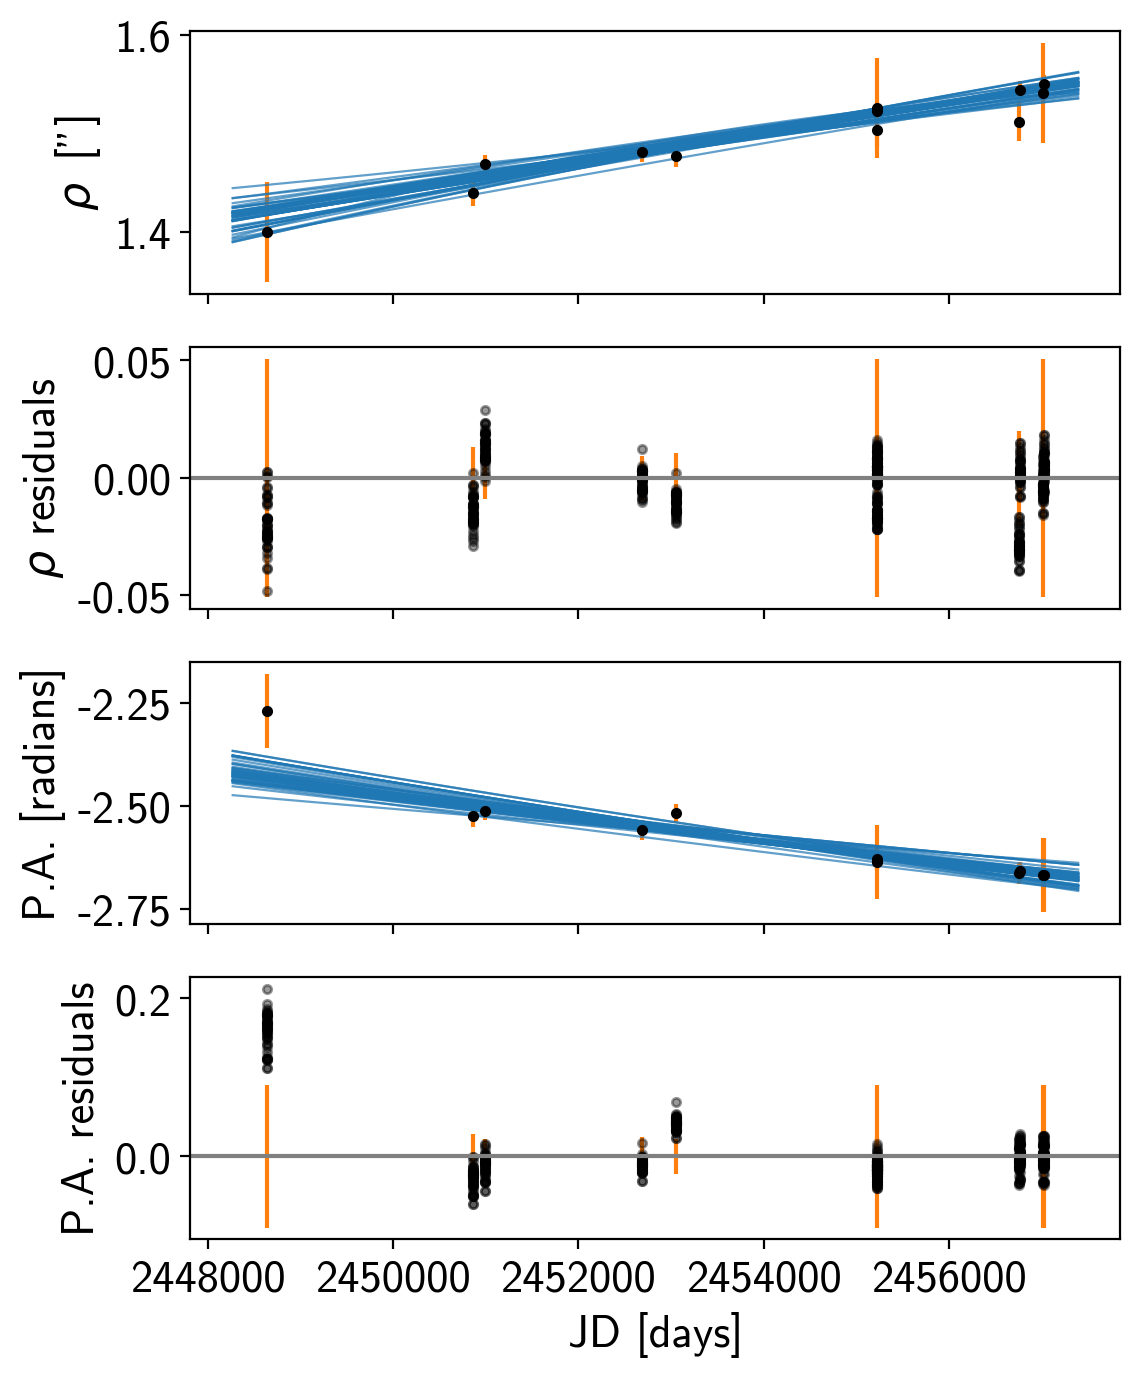

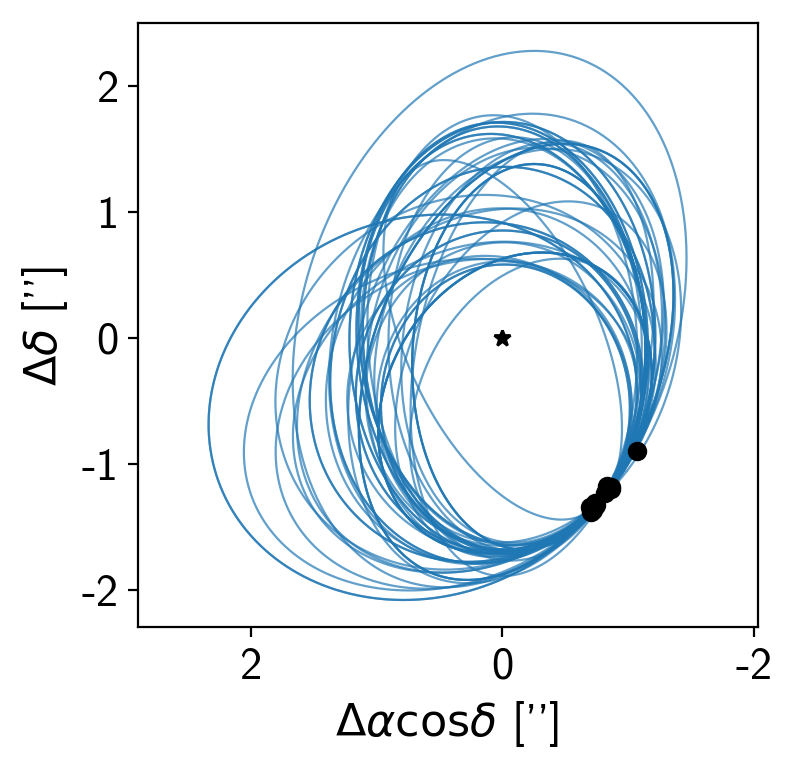

In [88]:
# plot the orbits on the figure

# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

nsamples = 50
choices = np.random.choice(np.arange(nsamples), size=nsamples)

# get map sol for tot_rho_err

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["logRhoS"])))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["logThetaS"])))

    
fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')
ax[3].set_xlabel("JD [days]")    

with parallax_model:
    # iterate through trace object
    for i in choices:
        
        pos = trace[i] 
    
        t_pred = pos["tPeriod"]
        rho_pred = pos["rhoSaveSky"]
        theta_pred = pos["thetaSaveSky"]

        x_pred = rho_pred * np.cos(theta_pred) # X north
        y_pred = rho_pred * np.sin(theta_pred) # Y east
    
        ax[0].plot(jd0 + t_data, pos["rhoSaveData"], color="C0", lw=0.8, alpha=0.7)
        
        ax[1].plot(jds, rho_data - xo.eval_in_model(rho_model, pos), **pkw, alpha=0.4)

        ax[2].plot(jd0 + t_data, pos["thetaSaveData"], color="C0", lw=0.8, alpha=0.7)

        ax[3].plot(jds, theta_data - xo.eval_in_model(theta_model, pos), **pkw, alpha=0.4)

        ax_sky.plot(y_pred, x_pred, color="C0", lw=0.8, alpha=0.7)
        
        

ax[0].plot(jds, rho_data, **pkw)
ax[0].errorbar(jds, rho_data, yerr=tot_rho_err, **ekw)
    
ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(jds, np.zeros_like(jds), yerr=tot_rho_err, **ekw)

ax[2].plot(jds, theta_data, **pkw)
ax[2].errorbar(jds, theta_data, yerr=tot_theta_err, **ekw)
    
ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(jds, np.zeros_like(jds), yerr=tot_theta_err, **ekw) 


ax_sky.plot(ys, xs, "ko")
ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax_sky.invert_xaxis()
ax_sky.plot(0,0, "k*")
ax_sky.set_aspect("equal", "datalim")

In [98]:
pm.backends.ndarray.save_trace(trace, directory="may17", overwrite=True)

'may17'